In [1]:
# model implementation
from ml.models.nn import MLP
from ml.algorithms.optimization import BackpropSGD
from ml.functions.activation import Sigmoid, Identity, Relu

# model selection
from ml.model_selection import GridSearchCV
from ml.functions.metrics.regression import RMSE, MAE, MRE

# data manipulation
from ml.dataset import load_csv, split_train_test
from ml.algorithms.normalization import MinMaxScaler

# Utility
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(25)

## Q1 - Neural Net for regression

### Load dataset
I'm using my implmenentation of k-fold with cross validation to find best hyperparameters.

The code which splits the dataset into **train, validation and test** is left for reference.

In [2]:
X, y = load_csv('./datasets/concrete.csv')

#### Split into train (60%), validation (20%) and test (20%) - unused

In [3]:
# X_train, y_train, X_test, y_test = split_train_test(X, y, 0.6, shuffle=True)
# X_train, y_train, X_val, y_val = split_train_test(X_train, y_train, 0.75, shuffle=False)

#### Split into train (70%) and test (30%)

In [4]:
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.7, shuffle=True)

### Scale data

In [5]:
# create min-max scalers
x_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

# scale train data
X_train_scaled = x_scaler.transform(X_train)
y_train_scaled = y_scaler.transform(y_train)

# scale test data
X_test_scaled = x_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

### Find best hyperparameters (num neurons and activation function) using grid search

In [6]:
grid = GridSearchCV()

# fixed hyperparams
reg = 0.001
momentum=0.8

# for lr in [0.2, 0.1, 0.01]:
for lr in [0.1]:
    for num_neurons in [16]:
        for function in [Relu, Sigmoid]:

            solver = BackpropSGD(epochs=1000,
                        learning_rate=lr,     # <-- hyperparam under test
                        regularization=reg,
                        momentum=momentum,
                        batch_size=32,
                        metrics=RMSE())

            layers = (
                (num_neurons, function()),     # <-- hyperparams under test
                (1, Identity()),
            )

            grid.add(MLP, {
                "layers":layers,
                "solver": solver})

best = grid.search(X_train_scaled, y_train_scaled, num_folds=10, shuffle=False)

### Hyperparameters of the best MLP

In [7]:
print("Best hyperparameters for MLP:", best[1])

Best hyperparameters for MLP: {'layers': ((16, Sigmoid), (1, Identity)), 'solver': Epochs=1000, LearningRate=0.1, Regularization=0.001, Momentum=0.8}


In [8]:
solver = BackpropSGD(epochs=1000,
                    learning_rate=0.1,
                    regularization=0.001,
                    momentum=0.8,
                    batch_size=32,
                    metrics=RMSE())
# 
layers = (
    (16, Sigmoid()),  # <-- hyperparams we are evaluating
    (1, Identity()),
)
# 
mlp = MLP(layers=layers, solver=solver)
train_err, test_err = mlp.fit(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

### Train MLP with best hyperparameters

In [9]:
mlp = MLP(**best[1])
train_err, test_err = mlp.fit(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

### Report train and test errors during training

Text(0.5, 0, 'Epoch')

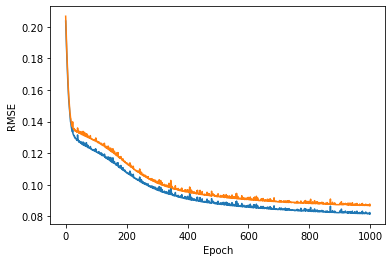

In [10]:
plt.plot(train_err)
plt.plot(test_err)

plt.ylabel("RMSE")
plt.xlabel("Epoch")

### Report train and test RMSE, MAE and MRE

In [11]:
y_train_pred_scaled = mlp.predict(X_train_scaled)
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)

y_test_pred_scaled = mlp.predict(X_test_scaled)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)

rmse = RMSE()
mae = MAE()
mre = MRE()

print("--\nRMSE(train):", rmse.measure(y_train, y_train_pred), "\nRMSE (test): ", rmse.measure(y_test, y_test_pred))
print("--\nMAE(train):",   mae.measure(y_train, y_train_pred), "\nMAE (test): ",   mae.measure(y_test, y_test_pred))
print("--\nMRE(train):",  rmse.measure(y_train, y_train_pred), "\nMRE (test): ",  rmse.measure(y_test, y_test_pred))

--
RMSE(train): 6.54800486970027 
RMSE (test):  6.967964793844331
--
MAE(train): 4.98671603334992 
MAE (test):  5.363343606236673
--
MRE(train): 6.54800486970027 
MRE (test):  6.967964793844331
